## Plot all FT's

In [1]:
from pathlib import Path
from skimage import io
import numpy as np
import napari
from os.path import exists
from brainlit.utils.session import NeuroglancerSession
from cloudvolume.exceptions import SkeletonDecodeError
from napari_animation import AnimationWidget
from cloudvolume import CloudVolume
from brainlit.utils import NeuronTrace
from pynufft import NUFFT
from tqdm import tqdm

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib widget


dir = "precomputed://s3://open-neurodata/brainlit/brain1"
dir_segments = "precomputed://s3://open-neurodata/brainlit/brain1_segments"
mip = 0
vol = CloudVolume(dir_segments, mip=mip)

num_goal = 0
num = -1
skel_id = -1

while num < num_goal:
    skel_id += 1
    try:
        skel = vol.skeleton.get(skel_id)
        print(f"Skeleton # {skel_id} exists")
        num += 1
    except SkeletonDecodeError:
        print(f"#{skel_id} invalid")

neuron = NeuronTrace(dir_segments, seg_id=skel_id, mip=mip, rounding=False)

paths = neuron.get_paths()  # coordinates are in nm

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


#0 invalid
#1 invalid
Skeleton # 2 exists


Looping through paths: 100%|██████████| 10/10 [00:00<00:00, 187.29it/s]


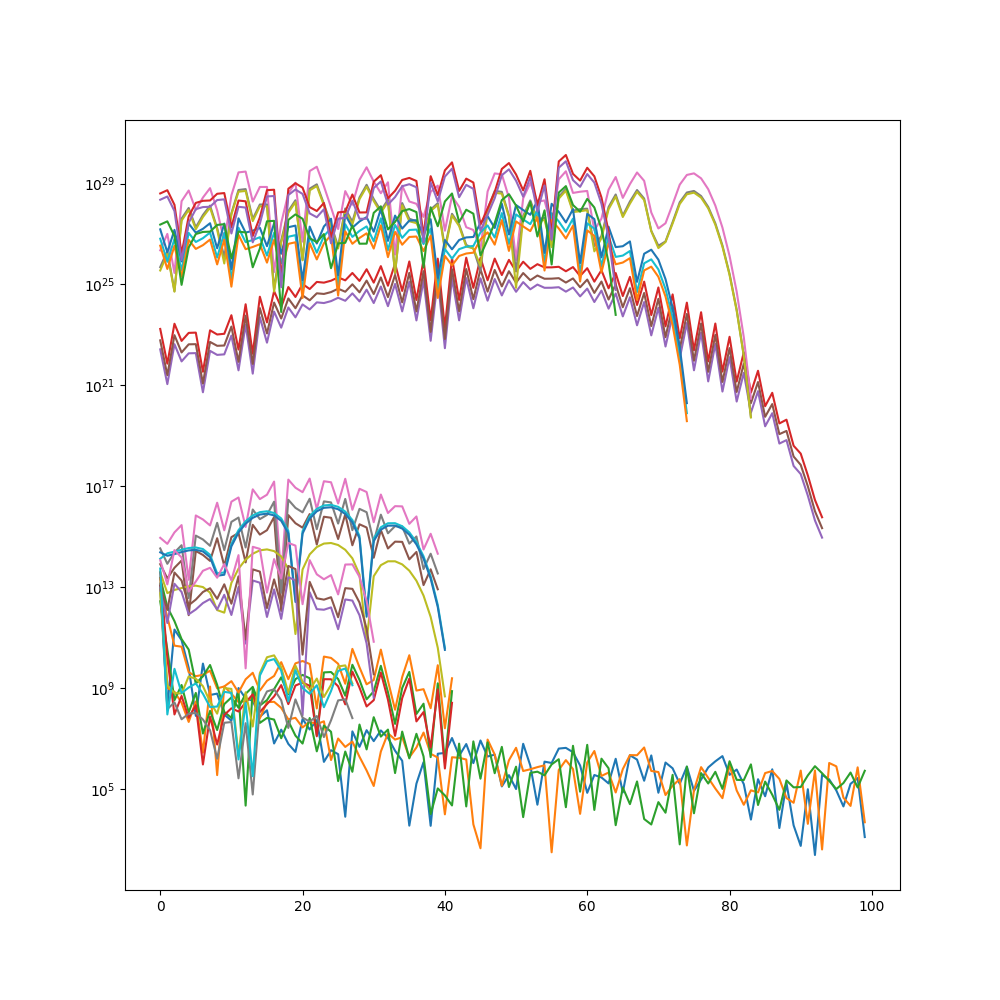

In [38]:
max_k = 100

fig_coeffs = plt.figure(figsize=(10, 10))
ax_coeffs = plt.axes()


for path in tqdm(paths[:10], desc="Looping through paths"):
    diffs = np.diff(path, axis=0)
    norms = np.linalg.norm(diffs, axis=1)
    norms = np.concatenate(([0], norms))
    ts = np.cumsum(norms)
    ts = ts / ts[-1]

    Y = path

    k = np.amin([path.shape[0], max_k])

    Psi = np.ones((len(ts), k))
    for l in range(1, k):
        col = np.sqrt(2) * np.cos(l * np.pi * ts)
        Psi[:, l] = col

    C_hat = np.linalg.pinv(Psi) @ Y

    # fig_neuron = plt.figure(figsize=(10, 10))
    # ax_neuron = plt.axes(projection='3d')
    # ax_neuron.plot3D(Y[:,0], Y[:,1], Y[:,2], label="true")

    for l in range(2, k, 10):
        Y_hat = Psi[:, :l] @ C_hat[:l, :]
        # ax_neuron.plot3D(Y_hat[:,0], Y_hat[:,1], Y_hat[:,2], label=f"k={l}")

    Y_hat = Psi @ C_hat
    # ax_neuron.plot3D(Y_hat[:,0], Y_hat[:,1], Y_hat[:,2], label=f"k={k}")

    # ax_neuron.legend()
    # plt.show()

    Cs = np.abs(C_hat) ** 2
    ax_coeffs.plot(np.arange(k), Cs[:, 0], label="x")
    ax_coeffs.plot(np.arange(k), Cs[:, 1], label="y")
    ax_coeffs.plot(np.arange(k), Cs[:, 2], label="z")

ax_coeffs.set_yscale("log")
plt.show()